## PROYECTO FINAL 
### UTP / MAESTRIA: ANALITICA DE DATOS
#### MATERIA: BIG DATA
##### ELABORADO POR: FRANCISCO D. TUDISCO


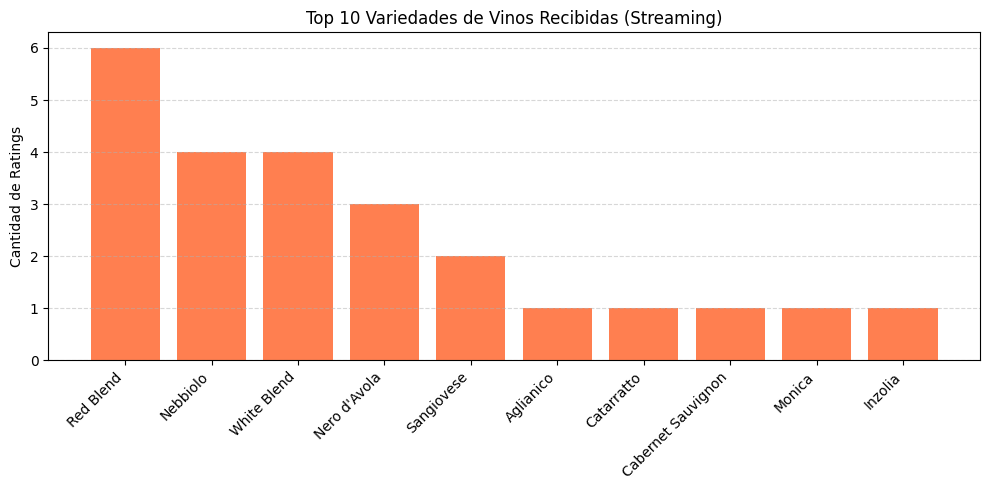

✅ Consumidor y conexión a Cassandra cerrados.


In [5]:
# Visualizacion y Consumo de Kafka
%matplotlib inline
import json
import uuid
import time
import pandas as pd
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
from IPython.display import clear_output

# Configurar Kafka
consumer = KafkaConsumer(
    'test',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='latest',
    enable_auto_commit=True,
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
    consumer_timeout_ms=30000  # Auto-exit after 10s idle
)

# Configurar Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('projectofinal')


# Variables de control
batch_size = 20
batch = []
historico = []

print("⏳ Escuchando en el tópico 'test'...")

try:
    for msg in consumer:
        event = msg.value

        event_id = uuid.uuid4()
        points = float(event.get("Points", 0)) if event.get("Points") else None
        prices = float(event.get("Prices", 0.0)) if event.get("Prices") else None

        row = (
            event_id,
            event.get("country"),
            event.get("description"),
            event.get("designation"),
            points,
            prices,
            event.get("province"),
            event.get("region_1"),
            event.get("region_2"),
            event.get("variety"),
            event.get("winery")
        )

        batch.append(row)
        historico.append({
            'variety': event.get("variety"),
            'Points': points
        })

        # Mantener solo últimos 50
        if len(historico) > 50:
            historico = historico[-50:]
        # Visualizar cada evento
        clear_output(wait=True)
        df = pd.DataFrame(historico)
        if not df.empty and df['Points'].notnull().any():
            top_ranking = (
                df.groupby('variety')['Points'].count()
                .reset_index()
                .sort_values(by='Points', ascending=False)
                .head(10)
            )
            plt.figure(figsize=(10, 5))
            plt.bar(top_ranking['variety'], top_ranking['Points'], color='coral')
            plt.ylabel("Cantidad de Ratings")
            plt.title("Top 10 Variedades de Vinos Recibidas (Streaming)")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.show()
            time.sleep(0.5)

except KeyboardInterrupt:
    print("\n🛑 Interrupción manual. Saliendo...")

finally:
    consumer.close()
    cluster.shutdown()
    print("✅ Consumidor y conexión a Cassandra cerrados.")
